In this assignment, your task is to put your new skils to use in the form of an open-ended, exploratory data analysis. In particular, I'm looking for you to demonstrate your ability to use the programmatic tools we've been learning to access data, manipulate it, and visualize some findings while working towards the ultimate goal of developing a final project proposal. Please include the following in your assignment:

1) A brief summary of the topic (a few sentences)

2) Access 2 or more datasets, at least one of them using an API (if you are not using any data from an API as part of your project yet, don’t worry about it, and just do this to get some exercise using APIs. You might use it later).

3) Demonstrate the use of Pandas operations to filter out missing data and/or outliers.

4) Demonstrate your capacity to use some of the "group-by" operations to produce pivot tables or statistical summaries of your data.

5) Use Matplotlib or Seaborn to produce 2-3 data visualizations of your data to both explore the data and highlight any notable patterns.

6) Include a short written analysis of your interpretation of the data.

7) In a few paragraphs, describe the research question you intend to investigate in your final project, and the plan for the data analysis you intend to perform.

Note that this exercise is intended to help you formulate your project topic. But it is not a binding contract. Your project will most likely evolve over the rest of the semester. So use this as an opportunity to be creative, throw some ideas against the wall and see what sticks. I will release the final project guidelines shortly. In the meantime, dig in!

And as always, please submit this assignment both as a PR on GitHub along with the URL of your PR on bCourses

#### Group Members: Breitling Snyder, Gabe Haddad

### 1) Summary

For our final project, we want to investigate travel patterns in San Francisco, particularly involving car use as it relates to demographics and transit infrastructure. For our initial analysis,  we are looking at patterns in parking violations. We use parking citation data (from the City of San Francisco data portal) to explore the spatial distribution of citations and how they may relate to demographic data by Census Tract (from ACS 5-year estimates, pulled using an API.) We check to see how the spatial distribution of parking citations is correlated with the income, housing tenure, property value, and education level of the census tract where they were issued.

In [ ]:
pip install census

In [5]:
pip install us

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for jellyfish==0.11.2 from https://files.pythonhosted.org/packages/a1/3c/0bfd98febe38c995f8bb72c898f218ddf2d3e5ffe0586bfb21308a747d0d/jellyfish-0.11.2-cp311-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/208.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/208.0 kB ? eta -:--:--
   ----- --------------------------------- 30.7/208.0 kB 435.7 kB/s eta 0:00:01
   ----------- --------------------------- 61.4/208.0 kB 544.7 kB/s eta 0:00:01
   -------------------------- ----------- 143.4/208.0 kB 944.1 kB/s eta 0:00:01
   ---------------------------------------- 208.0/208.0 kB 1.1 MB/s eta 0:00:00
  Created wheel for us: filename=us-3.1.1-py3-none-any.whl size=12612 sha256=aede73001045f9fe3eb374fe6ab16a1df3deebcf4fe1d4155af97ee06045cbd5
  Stored in directory: c:\users\breit\appdata\local\pip\cache\wheels\88\1

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sb
from census import Census
from us import states
import os
import mapbox
from mapbox import Geocoder
import requests
from shapely.geometry import Point


In [72]:
import matplotlib.pyplot as plt

### 2) Datasets

In [37]:
# Read in SFMTA Parking Citations data from January 2022. Over 91K rows
# DO NOT RUN THESE, geocoded data is attached

citations_path = 'SFMTA_Parking_Citations.csv' # I tried using an API for this, couldn't get it to work
citations = gpd.read_file(citations_path)

In [42]:
# Delete miscellaneous columns

citations = citations.iloc[:, :-7]

In [43]:
citations

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added
0,PD35242281,01/01/2022 12:00:00 AM,V5204A,REG TABS,50 TURK STREET,CA,5KVM701,478,04/10/2022 12:00:00 AM
1,PD35242270,01/01/2022 12:00:00 AM,V22500I,BUS ZONE,34 TURK STREET,CA,8YXC162,357,01/27/2022 12:00:00 AM
2,PD35242303,01/01/2022 12:00:00 AM,TRC7.2.42,RESTRICTED,66 TURK STREET,CA,8GPH125,106,03/14/2023 12:00:00 AM
3,PD36899155,01/01/2022 01:00:00 AM,PK6.01H,MAR GRN PK,110 YACHT ROAD/MARINA GREEN,CA,5GVD170,23,02/08/2022 12:00:00 AM
4,PD36180874,01/01/2022 01:13:00 AM,V22500E,DRIVEWAY,MANSELL/JOHN F SHELLEY,CA,5AHB142,110,03/15/2022 12:00:00 AM
...,...,...,...,...,...,...,...,...,...
91046,947667140,01/31/2022 11:20:00 PM,V5204A,REG TABS,375 06TH ST,CA,5TTR036,121,05/08/2022 12:00:00 AM
91047,947888712,01/31/2022 11:21:00 PM,V22500E,DRIVEWAY,3749 DIVISADERO ST,CA,AM47G84,108,02/10/2022 12:00:00 AM
91048,947888723,01/31/2022 11:34:00 PM,V22500E,DRIVEWAY,3749 DIVISADERO ST,CA,AM47G84,108,02/10/2022 12:00:00 AM
91049,PD37009431,02/01/2022 12:00:00 AM,TRC7.2.41,PK PHB OTD,101 GROVE STREET,CA,5LZZ399,108,05/04/2022 12:00:00 AM


In [55]:
geocoder = Geocoder(access_token='pk.eyJ1IjoiYnJlaXRsaW5nc255IiwiYSI6ImNsdGt3c3hwbDAwZnMybG84M3U3ajF5bDkifQ.eYpujFbLCMwonp5n2eGJrA')

In [58]:
# Specify location for geocoder

addrs = citations['Citation Location'] + " San Francisco, CA"

In [60]:
# Iterate through rows to geocode each address and save to a new dataframe
# This took approx 5 hours

data = pd.DataFrame(index=[], columns=['address','lat','lon'])

for i in range(len(addrs)):
    geoadress=geocoder.forward(addrs[i], limit = 1).geojson()['features'][0]['geometry']['coordinates']
    data.loc[i, 'address']=addrs[i]
    data.loc[i, 'lon']=geoadress[0]
    data.loc[i, 'lat']=geoadress[1]
data

,address,lat,lon
0,"50 TURK STREET San Francisco, CA",37.783593,-122.410065
1,"34 TURK STREET San Francisco, CA",37.783503,-122.409797
2,"66 TURK STREET San Francisco, CA",37.783523,-122.410299
3,"110 YACHT ROAD/MARINA GREEN San Francisco, CA",37.779026,-122.419906
4,"MANSELL/JOHN F SHELLEY San Francisco, CA",37.720505,-122.417333
...,...,...,...
91046,"375 06TH ST San Francisco, CA",37.78241,-122.4645
91047,"3749 DIVISADERO ST San Francisco, CA",37.804306,-122.444037
91048,"3749 DIVISADERO ST San Francisco, CA",37.804306,-122.444037
91049,"101 GROVE STREET San Francisco, CA",37.778169,-122.418569


In [62]:
# Name indexes

citations = citations.rename_axis('index')
data = data.rename_axis('index')

In [71]:
# Merge dataframes on indexes

cit_GC = pd.merge(citations, data, on='index')

In [133]:
# Turn (lat,lon) into a Point type geometry

geometry = [Point(xy) for xy in zip(cit_GC['lon'], cit_GC['lat'])]
cit_gdf = gpd.GeoDataFrame(cit_GC, geometry=geometry)

In [134]:
# Drop miscellaneous columns

cit_gdf = cit_gdf.drop(columns=['address','lat', 'lon'])

In [5]:
cit_gdf

,index,Citation N,Citation I,Violation,Violatio_1,Citation L,Vehicle Pl,Vehicle _1,Fine Amoun,Date Added,geometry
0,0,PD35242281,01/01/2022 12:00:00 AM,V5204A,REG TABS,50 TURK STREET,CA,5KVM701,478,04/10/2022 12:00:00 AM,POINT (-122.41007 37.78359)
1,1,PD35242270,01/01/2022 12:00:00 AM,V22500I,BUS ZONE,34 TURK STREET,CA,8YXC162,357,01/27/2022 12:00:00 AM,POINT (-122.40980 37.78350)
2,2,PD35242303,01/01/2022 12:00:00 AM,TRC7.2.42,RESTRICTED,66 TURK STREET,CA,8GPH125,106,03/14/2023 12:00:00 AM,POINT (-122.41030 37.78352)
3,3,PD36899155,01/01/2022 01:00:00 AM,PK6.01H,MAR GRN PK,110 YACHT ROAD/MARINA GREEN,CA,5GVD170,23,02/08/2022 12:00:00 AM,POINT (-122.41991 37.77903)
4,4,PD36180874,01/01/2022 01:13:00 AM,V22500E,DRIVEWAY,MANSELL/JOHN F SHELLEY,CA,5AHB142,110,03/15/2022 12:00:00 AM,POINT (-122.41733 37.72051)
...,...,...,...,...,...,...,...,...,...,...,...
91046,91046,947667140,01/31/2022 11:20:00 PM,V5204A,REG TABS,375 06TH ST,CA,5TTR036,121,05/08/2022 12:00:00 AM,POINT (-122.46450 37.78241)
91047,91047,947888712,01/31/2022 11:21:00 PM,V22500E,DRIVEWAY,3749 DIVISADERO ST,CA,AM47G84,108,02/10/2022 12:00:00 AM,POINT (-122.44404 37.80431)
91048,91048,947888723,01/31/2022 11:34:00 PM,V22500E,DRIVEWAY,3749 DIVISADERO ST,CA,AM47G84,108,02/10/2022 12:00:00 AM,POINT (-122.44404 37.80431)
91049,91049,PD37009431,02/01/2022 12:00:00 AM,TRC7.2.41,PK PHB OTD,101 GROVE STREET,CA,5LZZ399,108,05/04/2022 12:00:00 AM,POINT (-122.41857 37.77817)


In [137]:
cit_gdf.crs = 'EPSG:4269'

In [ ]:
# Save the shapefile

cit_gdf.to_file('Jan2022_Citations.shp')

## Run this one!

In [2]:
# After the first run, only need to run the following line to pull all citations:

cit_gdf = gpd.read_file('Jan2022_Citations.shp')

In [3]:
cit_gdf

,index,Citation N,Citation I,Violation,Violatio_1,Citation L,Vehicle Pl,Vehicle _1,Fine Amoun,Date Added,geometry
0,0,PD35242281,01/01/2022 12:00:00 AM,V5204A,REG TABS,50 TURK STREET,CA,5KVM701,478,04/10/2022 12:00:00 AM,POINT (-122.41007 37.78359)
1,1,PD35242270,01/01/2022 12:00:00 AM,V22500I,BUS ZONE,34 TURK STREET,CA,8YXC162,357,01/27/2022 12:00:00 AM,POINT (-122.40980 37.78350)
2,2,PD35242303,01/01/2022 12:00:00 AM,TRC7.2.42,RESTRICTED,66 TURK STREET,CA,8GPH125,106,03/14/2023 12:00:00 AM,POINT (-122.41030 37.78352)
3,3,PD36899155,01/01/2022 01:00:00 AM,PK6.01H,MAR GRN PK,110 YACHT ROAD/MARINA GREEN,CA,5GVD170,23,02/08/2022 12:00:00 AM,POINT (-122.41991 37.77903)
4,4,PD36180874,01/01/2022 01:13:00 AM,V22500E,DRIVEWAY,MANSELL/JOHN F SHELLEY,CA,5AHB142,110,03/15/2022 12:00:00 AM,POINT (-122.41733 37.72051)
...,...,...,...,...,...,...,...,...,...,...,...
91046,91046,947667140,01/31/2022 11:20:00 PM,V5204A,REG TABS,375 06TH ST,CA,5TTR036,121,05/08/2022 12:00:00 AM,POINT (-122.46450 37.78241)
91047,91047,947888712,01/31/2022 11:21:00 PM,V22500E,DRIVEWAY,3749 DIVISADERO ST,CA,AM47G84,108,02/10/2022 12:00:00 AM,POINT (-122.44404 37.80431)
91048,91048,947888723,01/31/2022 11:34:00 PM,V22500E,DRIVEWAY,3749 DIVISADERO ST,CA,AM47G84,108,02/10/2022 12:00:00 AM,POINT (-122.44404 37.80431)
91049,91049,PD37009431,02/01/2022 12:00:00 AM,TRC7.2.41,PK PHB OTD,101 GROVE STREET,CA,5LZZ399,108,05/04/2022 12:00:00 AM,POINT (-122.41857 37.77817)


## Now get Census data using an API and merge it with TIGER/Line shapefile to merge Polygon geometries

In [4]:
# Download census tract Polygon geometries from TIGER/Line shapefile

tracts_path = 'tl_2022_06_tract.shp'
tract_geoms = gpd.read_file(tracts_path)

In [5]:
tract_geoms

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,037,137504,06037137504,1375.04,Census Tract 1375.04,G5020,S,3837562,0,+34.1480383,-118.5720594,"POLYGON ((-118.58119 34.14318, -118.58099 34.1..."
1,06,037,138000,06037138000,1380,Census Tract 1380,G5020,S,4472196,0,+34.1488008,-118.5910495,"POLYGON ((-118.60573 34.14585, -118.60561 34.1..."
2,06,037,139200,06037139200,1392,Census Tract 1392,G5020,S,1152028,0,+34.1756961,-118.5246446,"POLYGON ((-118.53082 34.18024, -118.52952 34.1..."
3,06,087,120901,06087120901,1209.01,Census Tract 1209.01,G5020,S,18372491,0,+37.0781624,-122.0154263,"POLYGON ((-122.04607 37.07105, -122.04505 37.0..."
4,06,087,120902,06087120902,1209.02,Census Tract 1209.02,G5020,S,6474889,0,+37.0628452,-122.0106243,"POLYGON ((-122.02513 37.04320, -122.02500 37.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06,001,444500,06001444500,4445,Census Tract 4445,G5020,S,1959283,0,+37.5342653,-122.0273658,"POLYGON ((-122.03998 37.52944, -122.03971 37.5..."
9125,06,001,450200,06001450200,4502,Census Tract 4502,G5020,S,1612601,0,+37.7224277,-121.9154123,"POLYGON ((-121.92582 37.72685, -121.92470 37.7..."
9126,06,001,450300,06001450300,4503,Census Tract 4503,G5020,S,3133641,0,+37.7106517,-121.9177272,"POLYGON ((-121.92929 37.72608, -121.92864 37.7..."
9127,06,105,000500,06105000500,5,Census Tract 5,G5020,S,3706834371,4577022,+40.3425806,-123.2757792,"POLYGON ((-123.54464 40.59402, -123.54445 40.6..."


In [38]:
# Use Census API to get relevant ACS 5-year estimate data for census tracts in SF County (same geography as SF City)

census_key = os.getenv("1719660c5cf7b520bebebe18a0d53269a60db8c8")

acs_var = ('NAME','B01001_001E', 'B06011_001E', 'B19013_001E', 'B15003_022E', 'B25003_003E', 'B25077_001E', 'B08015_001E')  # total pop, median income, 
county = '075'  # San Francisco
year = 2022

c = Census(census_key, year=year)
res = c.acs5.get(acs_var, {
    'for': 'tract:*',
    'in': 'state:{} county:{}'.format(states.CA.fips, county)
})

ACS_data = pd.DataFrame(res)

In [39]:
column_mapping = {'B01001_001E': 'tot_pop', 'B06011_001E': 'medinc_2019', 'B19013_001E': 'medHHinc_2019',
                 'B15003_022E': 'bach_deg', 'B25003_003E': 'renters', 'B25077_001E': 'med_propval',
                 'B08015_001E': 'comm_veh'}

# Rename columns
ACS_data = ACS_data.rename(columns=column_mapping)

In [40]:
ACS_data['GEOID']=ACS_data['state']+ACS_data['county']+ACS_data['tract']

In [41]:
ACS_data

,NAME,tot_pop,medinc_2019,medHHinc_2019,bach_deg,renters,med_propval,comm_veh,state,county,tract,GEOID
0,Census Tract 101.01; San Francisco County; Cal...,2121.0,69706.0,83816.0,927.0,1057.0,1590500.0,185.0,06,075,010101,06075010101
1,Census Tract 101.02; San Francisco County; Cal...,1908.0,23977.0,-666666666.0,224.0,701.0,1272500.0,275.0,06,075,010102,06075010102
2,Census Tract 102.01; San Francisco County; Cal...,2473.0,91455.0,147427.0,953.0,843.0,1814400.0,300.0,06,075,010201,06075010201
3,Census Tract 102.02; San Francisco County; Cal...,1859.0,114663.0,208750.0,814.0,776.0,1415700.0,260.0,06,075,010202,06075010202
4,Census Tract 103; San Francisco County; Califo...,3925.0,86250.0,149766.0,1451.0,1635.0,1142900.0,545.0,06,075,010300,06075010300
...,...,...,...,...,...,...,...,...,...,...,...,...
239,Census Tract 9805.01; San Francisco County; Ca...,129.0,11938.0,12169.0,0.0,118.0,-666666666.0,-666666666.0,06,075,980501,06075980501
240,Census Tract 9806; San Francisco County; Calif...,1172.0,65000.0,136250.0,216.0,200.0,717800.0,315.0,06,075,980600,06075980600
241,Census Tract 9809; San Francisco County; Calif...,315.0,80313.0,-666666666.0,127.0,132.0,-666666666.0,85.0,06,075,980900,06075980900
242,Census Tract 9901; San Francisco County; Calif...,0.0,-666666666.0,-666666666.0,0.0,0.0,-666666666.0,-666666666.0,06,075,990100,06075990100


In [42]:
ACS_df = ACS_data.merge(tract_geoms[['GEOID','ALAND','AWATER','INTPTLAT','INTPTLON','geometry']], 
                         left_on='GEOID', right_on='GEOID')

In [43]:
# Drop miscellaneous columns

ACS_df = ACS_df.drop(columns=['NAME','state', 'county', 'tract'])

In [82]:
# Create a GeoDataFrame

ACS_gdf = gpd.GeoDataFrame(ACS_df, geometry='geometry')

In [83]:
ACS_gdf

,tot_pop,medinc_2019,medHHinc_2019,bach_deg,renters,med_propval,comm_veh,GEOID,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,2121.0,69706.0,83816.0,927.0,1057.0,1590500.0,185.0,06075010101,667587,676264,+37.8083492,-122.4093204,"POLYGON ((-122.42108 37.81289, -122.42018 37.8..."
1,1908.0,23977.0,-666666666.0,224.0,701.0,1272500.0,275.0,06075010102,79556,0,+37.8046900,-122.4139437,"POLYGON ((-122.41689 37.80521, -122.41524 37.8..."
2,2473.0,91455.0,147427.0,953.0,843.0,1814400.0,300.0,06075010201,186873,0,+37.8013029,-122.4212147,"POLYGON ((-122.42484 37.80227, -122.42465 37.8..."
3,1859.0,114663.0,208750.0,814.0,776.0,1415700.0,260.0,06075010202,331839,295796,+37.8106454,-122.4245951,"POLYGON ((-122.42685 37.80902, -122.42682 37.8..."
4,3925.0,86250.0,149766.0,1451.0,1635.0,1142900.0,545.0,06075010300,268261,0,+37.8016200,-122.4156810,"POLYGON ((-122.41872 37.80593, -122.41838 37.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,129.0,11938.0,12169.0,0.0,118.0,-666666666.0,-666666666.0,06075980501,1471536,9769,+37.7162081,-122.4193463,"POLYGON ((-122.42722 37.71555, -122.42719 37.7..."
240,1172.0,65000.0,136250.0,216.0,200.0,717800.0,315.0,06075980600,2069958,2078453,+37.7231655,-122.3685424,"POLYGON ((-122.38694 37.72425, -122.38693 37.7..."
241,315.0,80313.0,-666666666.0,127.0,132.0,-666666666.0,85.0,06075980900,3602295,258160,+37.7462860,-122.3894769,"POLYGON ((-122.40711 37.73906, -122.40706 37.7..."
242,0.0,-666666666.0,-666666666.0,0.0,0.0,-666666666.0,-666666666.0,06075990100,0,70939179,+37.7621600,-122.5518622,"POLYGON ((-122.61228 37.81522, -122.58459 37.8..."


In [13]:
# Save the shapefile - RUN ONCE VARIABLES DECIDED

ACS_gdf.to_file('2022ACS_SF_byTract.shp')

C:\Users\breit\AppData\Local\Temp\ipykernel_14204\4050217693.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ACS_gdf.to_file('2022ACS_SF_byTract.shp')


In [46]:
citations_wTracts = gpd.sjoin(cit_gdf, ACS_gdf, how='left', predicate='intersects')

In [47]:
citations_wTracts = citations_wTracts.drop(columns=['index_right'])

In [69]:
citations_wTracts # This has 41 more rows than citations alone - why?

,index,Citation N,Citation I,Violation,Violatio_1,Citation L,Vehicle Pl,Vehicle _1,Fine Amoun,Date Added,...,medHHinc_2019,bach_deg,renters,med_propval,comm_veh,GEOID,ALAND,AWATER,INTPTLAT,INTPTLON
0,0,PD35242281,01/01/2022 12:00:00 AM,V5204A,REG TABS,50 TURK STREET,CA,5KVM701,478,04/10/2022 12:00:00 AM,...,39133.0,520.0,1881.0,-666666666.0,245.0,06075012503,108926.0,0.0,+37.7834657,-122.4105086
4,4,PD36180874,01/01/2022 01:13:00 AM,V22500E,DRIVEWAY,MANSELL/JOHN F SHELLEY,CA,5AHB142,110,03/15/2022 12:00:00 AM,...,12169.0,0.0,118.0,-666666666.0,-666666666.0,06075980501,1471536.0,9769.0,+37.7162081,-122.4193463
6,6,PD36997575,01/01/2022 02:45:00 AM,V5204A,REG TABS,2251 GREENWICH,CA,8XOD966,341,03/26/2023 12:00:00 AM,...,250001.0,1009.0,697.0,2000001.0,195.0,06075012802,199611.0,0.0,+37.7983583,-122.4385354
7,7,946687140,01/01/2022 07:00:00 AM,V22500E,DRIVEWAY,665 EDDY ST,CA,7SCR930,110,02/05/2023 12:00:00 AM,...,32589.0,201.0,881.0,-666666666.0,NaN,06075012406,62825.0,0.0,+37.7830940,-122.4192115
8,8,PD36969133,01/01/2022 08:02:00 AM,V5204A,REG TABS,ONE MARINA GREEN DR,CA,8FUE762,121,02/07/2022 12:00:00 AM,...,102358.0,1688.0,2502.0,-666666666.0,380.0,06075012405,295197.0,0.0,+37.7795195,-122.4174620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91046,91046,947667140,01/31/2022 11:20:00 PM,V5204A,REG TABS,375 06TH ST,CA,5TTR036,121,05/08/2022 12:00:00 AM,...,184617.0,2047.0,1438.0,1778800.0,1360.0,06075040200,531470.0,0.0,+37.7843303,-122.4683869
91047,91047,947888712,01/31/2022 11:21:00 PM,V22500E,DRIVEWAY,3749 DIVISADERO ST,CA,AM47G84,108,02/10/2022 12:00:00 AM,...,236158.0,1539.0,1544.0,2000001.0,970.0,06075012700,429259.0,250510.0,+37.8049771,-122.4447185
91048,91048,947888723,01/31/2022 11:34:00 PM,V22500E,DRIVEWAY,3749 DIVISADERO ST,CA,AM47G84,108,02/10/2022 12:00:00 AM,...,236158.0,1539.0,1544.0,2000001.0,970.0,06075012700,429259.0,250510.0,+37.8049771,-122.4447185
91049,91049,PD37009431,02/01/2022 12:00:00 AM,TRC7.2.41,PK PHB OTD,101 GROVE STREET,CA,5LZZ399,108,05/04/2022 12:00:00 AM,...,102358.0,1688.0,2502.0,-666666666.0,380.0,06075012405,295197.0,0.0,+37.7795195,-122.4174620


### Filtering and visualizing Citations data (Questions 3 & 5)

In [65]:
val_cts = citations_wTracts['Violatio_1'].value_counts()

Violatio_1
STR CLEAN     38968
MTR OUT DT    11101
RES/OT         9473
METER DTN      5411
REG TABS       3871
YEL ZONE       2327
NO PLATES      2305
PK PHB OTD     2069
DRIVEWAY       1719
PRK PROHIB     1685
DBL PARK       1407
PRK GRADE      1384
ON SIDEWLK     1237
RED ZONE       1055
TRK ZONE        808
WHITE ZONE      549
OT OUT DT       477
BUS ZONE        393
BLK BIKE L      388
OBSTRCT TF      378
FIRE HYD        377
OVR 18 " C      316
PUB PROP        309
PK STANDS       265
CNSTR TEMP      254
PK/CROSS        209
TMP PK RES      198
PK OVR 72H      188
FACIL CRG       174
PLT LEF/AT      172
WHLCHR ACC      138
FAILRPLPLA      136
ANGLE PARK      134
N/ W/I SPC      119
RESTRICTED      116
PLATECOVER      115
NO EV REG        94
B ZN NO DP       93
TRNST ONLY       80
MED DIVIDE       75
OT PK DT         74
MC PRKING        53
Name: count, dtype: int64

In [66]:
less_than_1000 = val_cts[val_cts < 1000]
entries_less_than_1000 = less_than_1000.index.tolist()

In [67]:
entries_less_than_1000

['TRK ZONE',
 'WHITE ZONE',
 'OT OUT DT',
 'BUS ZONE',
 'BLK BIKE L',
 'OBSTRCT TF',
 'FIRE HYD',
 'OVR 18 " C',
 'PUB PROP',
 'PK STANDS',
 'CNSTR TEMP',
 'PK/CROSS',
 'TMP PK RES',
 'PK OVR 72H',
 'FACIL CRG',
 'PLT LEF/AT',
 'WHLCHR ACC',
 'FAILRPLPLA',
 'ANGLE PARK',
 'N/ W/I SPC',
 'RESTRICTED',
 'PLATECOVER',
 'NO EV REG',
 'B ZN NO DP',
 'TRNST ONLY',
 'MED DIVIDE',
 'OT PK DT',
 'MC PRKING',
 'NO VIOL',
 'OT MTR PK',
 'PK INTER',
 'GREEN ZONE',
 'MAR GRN PK',
 'NOPL/PRDSP',
 'ON ST LST',
 'NOPRK 10P6',
 'DISOB SIGN',
 'PK FR LN',
 '3 FT WLCHR',
 'NO PERMIT',
 'INVALD PMT',
 'ONSTCARSH',
 'ON STREET',
 'PKG PROHIB',
 'SCH/PUB GD',
 'BLK/INTER',
 'OFF ST LST',
 'CM VEH RES',
 'FAIL DISPL',
 'ILL PKG',
 'SAFE/RED Z',
 'RR TRACKS',
 'PRMT WR CR',
 'B ZN XHTCH',
 'NO PERM',
 'RESTR PRK',
 'ABAND. VEH',
 'BL ZNE BLK',
 'OFF STREET',
 'PLT F/R',
 'STR CAR',
 'PROHIB PRK',
 'ENG IDLING',
 'OBSTRCT TR']

In [68]:
citations_wTracts = citations_wTracts[~citations_wTracts['Violatio_1'].isin(entries_less_than_1000)]

In [70]:
citations_wTracts['Violatio_1'].value_counts()

Violatio_1
STR CLEAN     38968
MTR OUT DT    11101
RES/OT         9473
METER DTN      5411
REG TABS       3871
YEL ZONE       2327
NO PLATES      2305
PK PHB OTD     2069
DRIVEWAY       1719
PRK PROHIB     1685
DBL PARK       1407
PRK GRADE      1384
ON SIDEWLK     1237
RED ZONE       1055
Name: count, dtype: int64

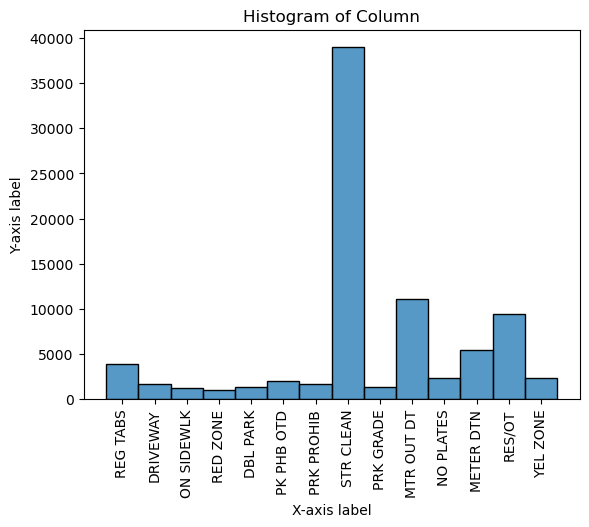

In [79]:
sb.histplot(data=citations_wTracts, x='Violatio_1', kde=False)
plt.xlabel('X-axis label')  # Replace 'X-axis label' with the label you want for the x-axis
plt.ylabel('Y-axis label')  # Replace 'Y-axis label' with the label you want for the y-axis
plt.title('Histogram of Column')  # Replace 'Histogram of Column' with your desired plot title
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

### Filter and visualize ACS data (Questions 3, 4 & 5)

In [87]:
ACS_gdf

,tot_pop,medinc_2019,medHHinc_2019,bach_deg,renters,med_propval,comm_veh,GEOID,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,2121.0,69706.0,83816.0,927.0,1057.0,1590500.0,185.0,06075010101,667587,676264,+37.8083492,-122.4093204,"POLYGON ((-122.42108 37.81289, -122.42018 37.8..."
2,2473.0,91455.0,147427.0,953.0,843.0,1814400.0,300.0,06075010201,186873,0,+37.8013029,-122.4212147,"POLYGON ((-122.42484 37.80227, -122.42465 37.8..."
3,1859.0,114663.0,208750.0,814.0,776.0,1415700.0,260.0,06075010202,331839,295796,+37.8106454,-122.4245951,"POLYGON ((-122.42685 37.80902, -122.42682 37.8..."
4,3925.0,86250.0,149766.0,1451.0,1635.0,1142900.0,545.0,06075010300,268261,0,+37.8016200,-122.4156810,"POLYGON ((-122.41872 37.80593, -122.41838 37.8..."
5,2437.0,84236.0,173750.0,653.0,610.0,1936400.0,340.0,06075010401,142234,0,+37.8027796,-122.4106880,"POLYGON ((-122.41488 37.80354, -122.41372 37.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,1567.0,183011.0,247063.0,290.0,544.0,1162500.0,160.0,06075061504,95344,0,+37.7852562,-122.3924125,"POLYGON ((-122.39516 37.78431, -122.39440 37.7..."
232,1061.0,119091.0,250001.0,382.0,168.0,1389500.0,175.0,06075061505,21283,0,+37.7891027,-122.3906438,"POLYGON ((-122.39097 37.79007, -122.38943 37.7..."
233,4541.0,203854.0,250001.0,1702.0,1573.0,1771500.0,430.0,06075061506,112895,0,+37.7876594,-122.3910165,"POLYGON ((-122.39396 37.78771, -122.39360 37.7..."
235,2222.0,145558.0,171915.0,358.0,502.0,1598000.0,70.0,06075061508,214282,165959,+37.7860679,-122.3863351,"POLYGON ((-122.39362 37.78308, -122.39284 37.7..."


In [85]:
ACS_gdf = ACS_gdf[(ACS_gdf != -666666666).all(axis=1)]

In [86]:
ACS_gdf = ACS_gdf.dropna()

In [90]:
ACS_gdf['medHHinc_2019'].describe()

count       206.000000
mean     151456.733010
std       51112.517561
min       19531.000000
25%      116188.250000
50%      148091.500000
75%      184339.500000
max      250001.000000
Name: medHHinc_2019, dtype: float64

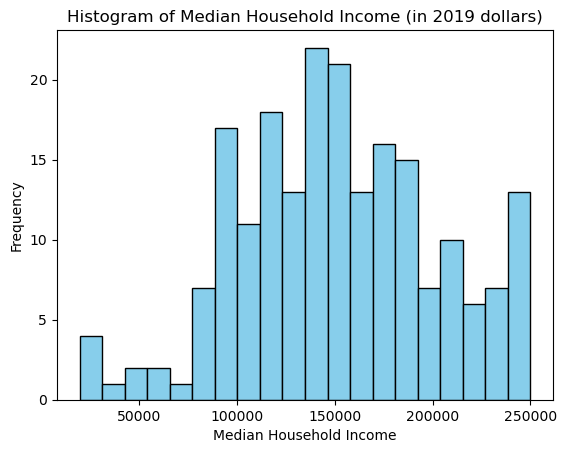

In [89]:
plt.hist(ACS_gdf['medHHinc_2019'], bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Median Household Income')
plt.ylabel('Frequency')
plt.title('Histogram of Median Household Income (in 2019 dollars)')

plt.show()

## 6 & 7) Preliminary Findings & Research Question

Our main research question is how different factors influence driving in the city of San Francisco. As transportation planning students, we have studied the link between car dependency and economic, environmental, and land use factors. The state of California has passed legislation mandating that local planning departments enact policies that reduce overall vehicle miles traveled (VMT). We hope to uncover what factors most influence VMT levels within San Francisco.

We intend to use a variety of data to investigate this topic. We are starting by looking at parking citations. The SFMTA provides public information about every citation issued in the city including the location and category of violation. By analyzing this data, we are investigating 1) where there is excess demand for parking in locations where curb space is heavily restricted and 2) what the enforcement patterns are for parking. We assume that citations are only issued in a small percentage of total parking violations, so understanding what factors influence where and when citations are issued helps us uncover what the parking enforcement patterns are. We hypothesize that citations are disproportionately issued in commercial corridors and in higher income residential neighborhoods.

Our first round of analysis involved identifying the most common types of parking violations. We cleaned our data to only include violation types with more than 1000 occurrences in the month of January 2022 so we had a better understanding of the data we are working with. We found that street cleaning and parking meter time limits were by far the most common categories. Our second step was to link housing tenure with violation frequencies. We intend to see what the correlation between income levels and parking violations are for tracts. As a first step, we found and plotted the distribution of income across tracts in the city. We found that the bulk of tracts fall between 100 and 200 thousand dollars with a high number at 250,000 and very low frequency at the low end of the income spectrum.

We also want to understand patterns of car usage over time. To do this, we plan on using car registration data for the city cross referenced with transit ridership. By looking at the number of car registrations and transit ridership each year, we can see if there is a link. On the trip level, we can see if transit rides replace driving by looking for an inverse relationship between car and transit trips. We can use commute data from the Census as well as transit ridership numbers provided by the SFMTA and the MTC’s VitalSigns VMT tracker. Tracking trends in VMT and transit ridership will help solidify our findings. We can make interactive charts using plotly to create a visualization with an interactive sliding scale for time that shows how VMT and transit ridership trend over time.

Another analysis we can make is the impact of rail versus bus on car usage. We can import the geodata on rail (Muni Metro and BART) stations and bus stations and use Census data that shows the number of vehicles used for commuting on a tract level. If we need to go to a lower level we can, but there should be interesting correlations between the number of transit stops within a tract and how many vehicles are used for commuting in that tract. We will plot the transit stops using matplotlib and use seaborn to color code the tracts based on the number of vehicles used for commuting. Then we can see if there is a link between transit access and auto commuting. We can also do a spatial join with the parking citation data to see what the link between auto commuting and parking citations is. A join with the demographic data can also help us understand which communities auto commute more.